# Monte Carlo sampling

We are going to demonstrate simple Monte Carlo (MC) sampling and show its (slow) convergence rate.

In [3]:
# uncomment to install numpy and/or matplotlib
#!pip install numpy
#!pip install matplotlib

In [4]:
import numpy as np
import matplotlib.pyplot as plt

We start by defining two random input variables, uniformly distributed between -1 and 1: 

\begin{align*}
x_i\sim\mathcal{U}[-1,1]
\end{align*}

The standard Numpy implementation `np.random.rand` gives samples drawn from $\mathcal{U}[0,1]$, which we linearly transform to the domain $[-1, 1]$:

In [5]:
def sample_input(N, a = -1, b = 1):
    """
    Generate random input samples, x_i ~ U[-1, 1]

    Parameters
    ----------
    N : integer
        The number of random input samples.
    a : float
        The left boundary, default is -1.
    b : float
        The right boundary, default is 1.

    Returns
    -------
    x1 : array
        N random samples from p(x_1).
    x2 : array
        N random samples from p(x_2).

    """

    x1 = np.random.rand(N) * (b - a) + a
    x2 = np.random.rand(N) * (b - a) + a

    return x1, x2

Below we define a function of $x_1$ and $x_2$ that computes an estimate of $\pi$ using MC sampling. 

![](./images/mc_pi.png)

We know that the area $A_2=4$. Furthermore, since the joint distribution over ${\bf x}=(x_1, x_2)$ inside the square is uniform, we also known that the ratio $A_1/A_2$ equals the probability that a random sample falls inside the circle, i.e.:

\begin{align}
\frac{A_1}{A_2} = \mathbb{P}\left({\bf x}\in A_1\right)
\end{align}

This is a probability we can approximate with MC sampling, by approximating the expected value (mean) of a simple indicator function:

\begin{align}
\mathbb{P}\left({\bf x}\in A_1\right) = \mathbb{E}\left[I({\bf x}\in A_1)\right] \approx \frac{1}{N}\sum_{i=1}^N I({\bf x}^{(i)}\in A_1)
\end{align}

Where

\begin{align}
I({\bf x}\in A_1) = 
\begin{cases}
1 & {\bf x}\in A_1\\
0 & \mathrm{otherwise}
\end{cases}
\end{align}

Thus, we simply compute the number of times a random sample produces a "hit" inside the circle, which should approach $A_1/A_2=\pi/4$ as $N\rightarrow\infty$.


In [6]:
def f(x1, x2):
    """
    Compute pi with MC sampling

    Parameters
    ----------
    x1 : float
        The 1st random input parameter, uniformly distributed within [-1,1].
    x2 : float
        The 2nd random input parameter, uniformly distributed within [-1,1].

    Returns
    -------
    hit : array
        The indices of samples inside the circle.
    miss : array
        The indices of samples outside the circle.
    pi_estimate : float
        The estimate of pi

    """

    # radius of all samples
    r = np.sqrt(x1 ** 2 + x2 ** 2)
    # total number of MC samples
    N = r.size

    hit = np.where(r <= 1)[0]
    miss = np.where(r > 1)[0]

    area_square = 4
    
    pi_estimate = hit.size / N * area_square
    
    return hit, miss, pi_estimate
    

In [9]:
# number of random input samples
N = 100
x1, x2 = sample_input(N)
hit, miss, pi_estimate = f(x1, x2)

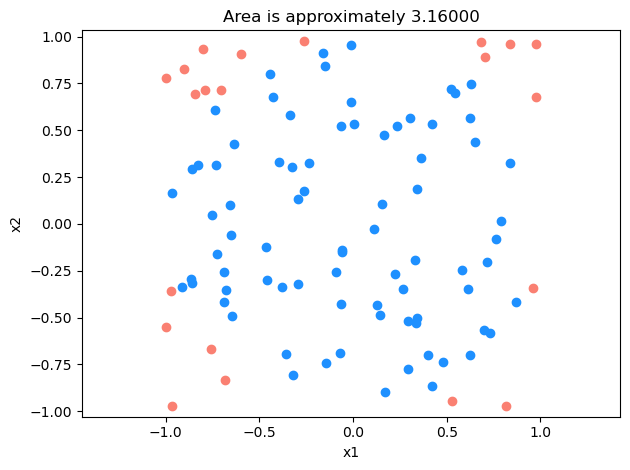

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, xlim=[-1, 1], ylim=[-1,1], 
                     title=r'Area is approximately %.5f' % pi_estimate,
                     xlabel="x1", ylabel="x2")
ax.plot(x1[hit], x2[hit], 'o', color='dodgerblue')
ax.plot(x1[miss], x2[miss], 'o', color='salmon')
plt.axis('equal')
plt.tight_layout()


For small $N$ the estimate of $\pi$ will likely be inaccurate, and can change significantly if you repeat the experiment. Increase `N` above to get a better estimate. Still, due to sampling error the estimate itself is a random variable. Below we systematically increase $N$, repeating the experiment multiple times at every N value:

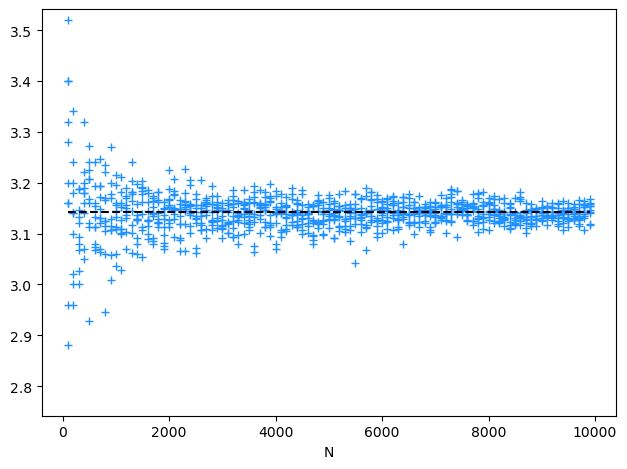

In [11]:
N_range = np.arange(10**2, 10**4, 100)
repeat = 10

fig = plt.figure()
ax = fig.add_subplot(111, xlabel="N", ylim=[np.pi - 0.4, np.pi + 0.4])

for N in N_range:
    for i in range(repeat):
        x1, x2 = sample_input(N)
        _, _, pi_estimate = f(x1, x2)
        ax.plot(N, pi_estimate, '+', color='dodgerblue')
        
# plot true value
ax.plot(N_range, np.pi * np.ones(N_range.size), '--k')
plt.tight_layout()

We can see convergence towards the true value, although at a rather slow rate. It is in fact $1/\sqrt{N}$ convergence, see the notes at the end of this notebook. 

Before ending, we will show one similar yet sligtly more interesting example than approximating the aera of a circle, namely approximating the area of the Mandelbrot set. Briefly, we have the very simple relationship 


\begin{align}
z_{n+1}=z_n^2 + c, \quad n=0,1,2,\cdots \\
z_0=0
\end{align}

where all variables are in the complex plane. For a given $c$, this relationship will either converge (in the set) or shoot off to infinity (not in the set). Despite the simplicity of the quadratic formula above, the Mandelbrot has a very complex shape (see below). However, we can still estimate its area in exactly the same manner as before, i.e. simply computing the mean hit rate with MC sampling:

In [12]:
def mandelbrot(c, max_iter):
    """
    Compute z_{n+1} = z^2_n + c for a given value of c, and a given number
    of maximum iterations n=1,2,...,max_iter.

    Parameters
    ----------
    c : complex
        The c value.
    max_iter : integer
        The maximum number of iterations.

    Returns
    -------
    n : integer
        The iteration count. If n < max_iter, the solution diverged (not in the set).

    """
    z = 0
    n = 0
    while abs(z) <= 2 and n < max_iter:
        z = z * z + c
        n += 1
    return n

def mandelbrot_area(N):
    """
    Plot the Mandelbrot set and use MC sampling to estimate its area.

    Parameters
    ----------
    N : integer
        The number of MC samples.

    Returns
    -------
    None.

    """

    max_iter = 80

    # left and right boundary of the square containing the Mandelbrot set
    a = -2; b = 2

    P = 300
    Z1 = np.linspace(a, b, P)
    Z2 = np.linspace(a, b, P)

    X, Y = np.meshgrid(Z1, Z2)
    M = np.zeros([P, P])

    for i, z1 in enumerate(Z1):
        for j, z2 in enumerate(Z2):
            n = mandelbrot(z1 + z2 * 1j, max_iter)
            if n == max_iter:
                M[i, j] = 1
            else:
                M[i, j] = 0

    # z1, z2 are uniformly distributed between -2 and 2              
    z1, z2 = sample_input(N, a = a, b = b)
    Z = z1 + z2 * 1j
    hit = 0

    for z in Z:
        n = mandelbrot(z, max_iter)
        if n == max_iter:
            hit += 1
    
    area_square = 16
    area_estimate = hit / N * area_square

    fig = plt.figure(111)
    ax = fig.add_subplot(111, title = r'Area is approximately %.5f' % (area_estimate,), xlabel = 'c1', ylabel = 'c2')
    ax.contourf(X, Y, M.T)
    plt.tight_layout()

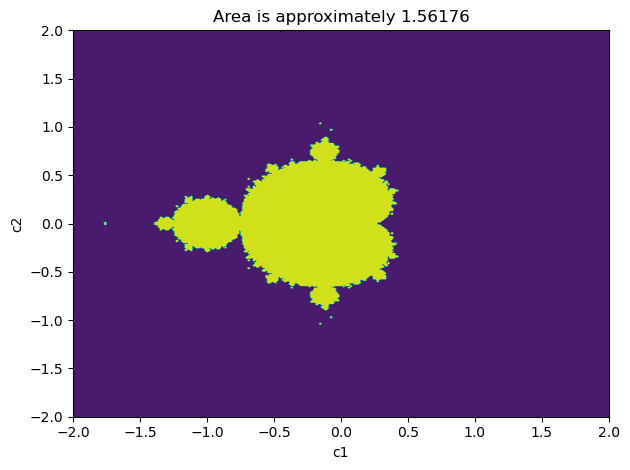

In [16]:
mandelbrot_area(100000)

## MC convergence rate

Let $Y$ be a random variable with mean $\mu$ and variance $\sigma^2$, and $y^{(i)}$ are i.i.d. (independent indentically distributed) samples drawn from its probability density function $p(Y)$. $Y$ could be the random output of a (computer) model with random inputs, $Y=f({\bf x})$. The sample mean $S_N$ is an estimate of $\mu$

\begin{align}
 \mu\approx S_N := \frac{1}{N}\sum_{n=1}^{N} y^{(i)},
\end{align}

and the standard deviation $\sqrt{\mathbb{V}\mathrm{ar}\left[S_N\right]}$ is an error estimate of the sample mean, which we will compute below. For this we need the following relations:

\begin{align}
\mathbb{V}\mathrm{ar}\left[cY\right] := \mathbb{E}\left[(cY - \mathbb{E}\left[cY\right])^2\right] = c^2\mathbb{E}\left[(Y - \mathbb{E}\left[Y\right])^2\right] = c^2\mathbb{V}\mathrm{ar}\left[Y\right]
\end{align}

where $c$ is a constant, and 

\begin{align}
\mathbb{V}\mathrm{ar}\left[\sum_i y^{(i)}\right] :&= \mathbb{E}\left[\left(\sum_i y^{(i)}\right)^2\right] - \left(\mathbb{E}\left[\sum_i y^{(i)}\right]\right)^2 \\
&= \mathbb{E}\left[\sum_i y^{(i)}\sum_j y^{(j)}\right] - \left(\mathbb{E}\left[\sum_i y^{(i)}\right]\right)\left(\mathbb{E}\left[\sum_j y^{(j)}\right]\right) \\
&= \sum_i\sum_j\left(\mathbb{E}\left[y^{(i)}y^{(j)}\right] - \mathbb{E}\left[y^{(i)}\right]\mathbb{E}\left[y^{(j)}\right]\right) \\
&= \mathbb{C}\mathrm{ov}\left[y^{(i)}, y^{(j)}\right]
\end{align}

However, since $y^{(i)}$ and $y^{(j)}$ are independent, they are also uncorrelated: $\mathbb{C}\mathrm{ov}\left[y^{(i)}, y^{(j)}\right]=0$ if $i\neq j$. Thus, for independent random variables, the variance of the sum is simply the sum of the individual variances (remember that the variances are on the diagonal of $\mathbb{C}\mathrm{ov}\left[y^{(i)}, y^{(j)}\right])$:

\begin{align}
\mathbb{V}\mathrm{ar}\left[\sum_i y^{(i)}\right] = \sum_i\mathbb{V}\mathrm{ar}\left[ y^{(i)}\right].
\end{align}


Now, we can write:

\begin{align}
 \mathbb{V}\mathrm{ar}\left[S_N\right] = \mathbb{V}\mathrm{ar}\left[\frac{1}{N}\sum_{i=1}^N y^{(i)}\right] = \frac{1}{N^2}\sum_{i=1}^N\mathbb{V}\mathrm{ar}\left[ y^{(i)}\right].
\end{align}

Moreover, since the $y^{(i)}$ are all identically distributed, we have $\mathbb{V}\mathrm{ar}\left[y^{(i)}\right] = \sigma^2$. Thus, the error estimate of $S_N$ is

\begin{align}
\sqrt{\mathbb{V}\mathrm{ar}\left[S_N\right]} = \sqrt{\frac{1}{N^2} N \sigma^2} = \frac{\sigma}{\sqrt{N}} \propto \frac{1}{\sqrt{N}}
\end{align}

So we can see that the error reduces with the square root of the number of MC samples, which is not great. However, since $\mathbb{E}\left[S_N\right] = 1/N\sum_i\mathbb{E}[ y^{(i)}] = 1/N  N  \mu = \mu$, the MC estimate is unbiased, i.e. on average, $S_N$ is correct. We can also observe this from the convergence plot of the $\pi$ example, as the true value runs through the middle of the point cloud.